In [1]:
pip install icecream

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import polars as pl
import math as m
import numpy as np
from icecream import ic
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
import seaborn as sns
import sklearn
# import ot
pl.Config.set_fmt_str_lengths(100)
import tensorflow
from tensorflow import keras
from keras import layers, models
from sklearn.preprocessing import LabelEncoder
import pickle
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout
from sklearn.preprocessing import StandardScaler
from keras.optimizers import RMSprop
from keras.utils import to_categorical
from sklearn.metrics import fbeta_score
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [4]:
print("Num GPUs Available: ", len(tensorflow.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


(4710, 10451) (2030, 10451) 4710 2030
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 256)               2675712   
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)

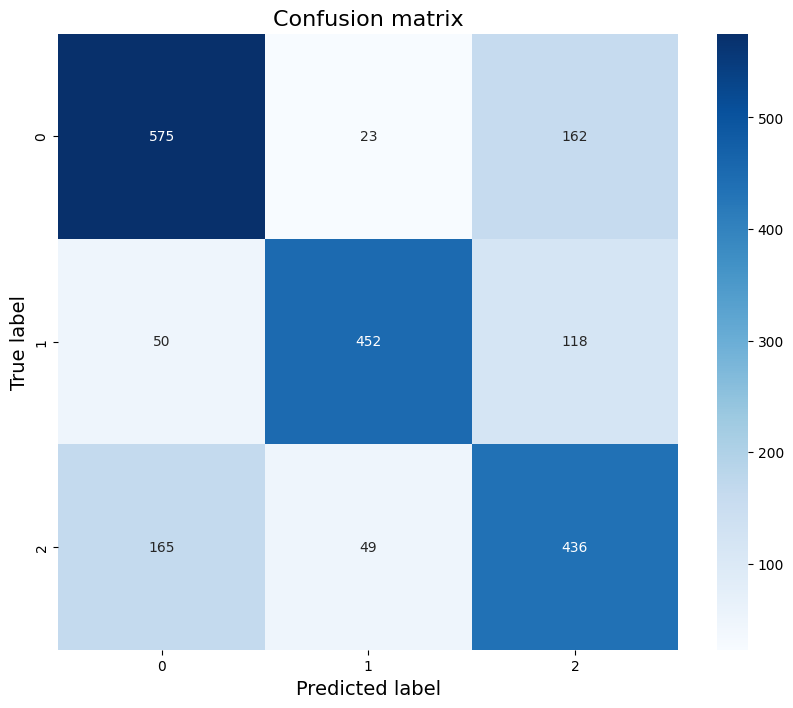

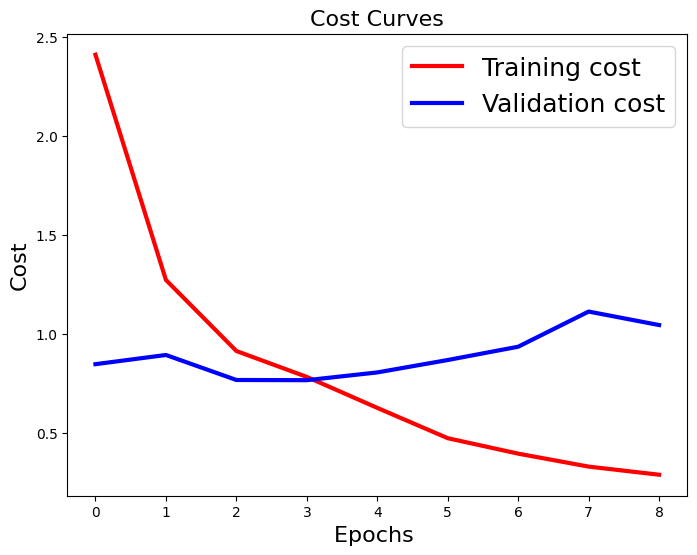

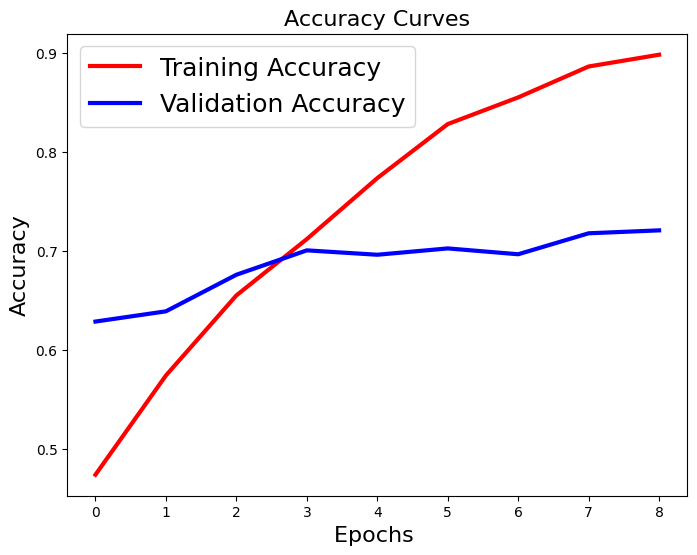

In [6]:
def pickleThis(path,file,pklname):
  with open(path+pklname+".pkl", 'wb') as f:
      pickle.dump(file, f)

def loadPickle(path,filename):
  with open(path+filename, 'rb') as f:
      return pickle.load(f)

def dfun(u, v)-> float:
    u = u/u.sum()
    v = v/v.sum()
    return ot.emd2_1d(u,v)

def get_distances(df, seg_lims):
    dist_m = {}
    get_seg = lambda x,y: list(range(x,y))
    # seg_lims = [0,1307,2613,5225,10451]
    freq_segments = [get_seg(seg_lims[i],seg_lims[i+1]) for i in range(len(seg_lims)-1)]
    for seg in freq_segments:
        X = df[:,seg]
        key = f'{seg[:1][0]/10451*2000:.0f}'
        print(key)
        dist_m[key] = squareform(pdist(X, dfun))
    return dist_m

def weighted_distance(weights:dict, dist_m:dict):
    s = 0
    for key in dist_m:
        s += dist_m[key]*weights[key]
    return s

def create_train_test_split(df):
    f_codes = df['fault_code'].to_list()

    f_str = set([f[4:-7] for f in f_codes]) #The slice f[4:-7] includes the element at the start index and all the elements up to but not including the stop index. If f is shorter than the range specified, or the start index is greater than the stop index, the result will be an empty sequence.
    # ic(f_str)
    index_fstr = {}
    fstr_index = {}
    val_list = []

    for f in f_str:
        index_fstr[f] = max([code[-6:-5] for code in f_codes if f in code]) #returns 0; for 'VIB_0200000@0@0_on' in f_codes if ''0200000' in ''VIB_0200000@0@0_on' --> take out max of code[-6:-5]= 020000(0) this element
        key = f"{f}@{index_fstr[f]}" # index_fstr = {'0200000': '0'}, f = '0200000', index_fstr[f] = 0 -- > key = f"{f}@{index_fstr[f]}" = 0200000@0
        fstr_index[key] = [i for i,code in enumerate(f_codes) if key in code] #fstr_index = {'0020000@0': 4150}
        val_list += fstr_index[key]

    # ic(fstr_index)
    val_set = set(val_list)
    full_set = set(list(range(df.shape[0])))
    train_list = list(full_set-val_set)
    # ic(len(train_list), len(val_set))
    return train_list, val_list

def create_train_val_test_split(df, test_size=0.2, val_size=0.25):
    # Create train, validation and test split
    train_list, temp_list = train_test_split(list(range(df.shape[0])), test_size=test_size)
    val_list, test_list = train_test_split(temp_list, test_size=val_size)

    return train_list, val_list, test_list

def create_train_val_test_data(df, train_list, val_list, test_list):
    col_ind = list(range(2,10453))
    X_train = df[train_list, col_ind].to_numpy()
    X_val = df[val_list, col_ind].to_numpy()
    X_test = df[test_list, col_ind].to_numpy()
    # ic(X_train, X_val)

    train_list_y = df["fault_code"][train_list].to_list()
    y_train = [t[7:8] for t in train_list_y]
    val_list_y = df["fault_code"][val_list].to_list()
    y_val = [t[7:8] for t in val_list_y]
    test_list_y = df["fault_code"][test_list].to_list()
    y_test = [t[7:8] for t in test_list_y]

    # ic(len(y_train), len(y_val))
    return(X_train, y_train, X_val, y_val, X_test, y_test)

def create_dataset(df, train_list, val_list):
    col_ind = list(range(2,10453))
    X_train = df[train_list, col_ind].to_numpy()
    X_val = df[val_list, col_ind].to_numpy()
    # ic(X_train, X_val)

    train_list_y = df["fault_code"][train_list].to_list()
    y_train = [t[7:8] for t in train_list_y]
    val_list_y = df["fault_code"][val_list].to_list()
    y_val = [t[7:8] for t in val_list_y]

    # ic(len(y_train), len(y_val))
    return(X_train, y_train, X_val, y_val)

if __name__ == "__main__":
    path = r"/content/drive/MyDrive/FML_Project/ax.feather"
    df = pl.read_ipc(path)[1:]

    train, val = create_train_test_split(df)
    x_train, y_train, x_val, y_val  = create_dataset(df, train,val)
    # print(x_train.shape, x_val.shape, len(y_train), len(y_val))

    # train_list, val_list, test_list = create_train_val_test_split(df)
    # x_train, y_train, x_val, y_val, x_test, y_test = create_train_val_test_data(df, train_list, val_list, test_list)

    path = r"/content/drive/MyDrive/FML_Project/"

    # Create Pickle
    pickleThis(path,x_train,"x_train")
    pickleThis(path,y_train,"y_train")
    pickleThis(path,x_val,"x_val")
    pickleThis(path,y_val,"y_val")
    # pickleThis(path,x_test,"x_test")
    # pickleThis(path,y_test,"y_test")

    # # Load data files
    x_train = loadPickle(path,"x_train.pkl")
    x_val = loadPickle(path,"x_val.pkl")
    # x_test = loadPickle(path,"x_test.pkl")

    y_train = loadPickle(path,"y_train.pkl")
    y_val = loadPickle(path,"y_val.pkl")
    # y_test = loadPickle(path,"y_test.pkl")

    # categorical
    encoder = LabelEncoder()
    y_train = encoder.fit_transform(y_train)
    y_train = np.array(y_train)  # Convert to numpy array

    y_val = encoder.fit_transform(y_val)
    y_val = np.array(y_val)

    # y_test = encoder.fit_transform(y_test)
    # y_test = np.array(y_test)

    # Scaling
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_val = scaler.fit_transform(x_val)
    # x_test = scaler.fit_transform(x_test)

    # One hot Encoding for y label
    y_train = to_categorical(y_train, num_classes=3)
    y_val = to_categorical(y_val, num_classes=3)
    # y_test = to_categorical(y_test, num_classes=3)

    print(x_train.shape, x_val.shape, len(y_train), len(y_val))

    # Input layer
    model = Sequential()
    model.add(Dense(256, input_dim=x_train.shape[1], activation='relu'))
    model.add(Dropout(0.5))  # Dropout layer
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))  # Dropout layer
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))  # Dropout layer
    model.add(Dense(32, activation='relu'))
    model.add(Dense(3, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

    print(model.summary())

    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)

    # history = model.fit(x_train, y_train, epochs=100, validation_data=(x_val, y_val))
    history = model.fit(x_train, y_train, epochs=100, validation_data=(x_val, y_val), callbacks=[early_stopping], verbose=0)

    val_loss, val_acc = model.evaluate(x_val, y_val)
    print('Validation accuracy:', val_acc)

    # Assuming y_val are the true class labels and y_pred are the predicted class labels
    y_pred = model.predict(x_val)
    y_pred = to_categorical(y_pred.argmax(axis=1), num_classes=3)

    f05 = fbeta_score(y_val, y_pred, beta=0.5, average='macro')
    f1 = fbeta_score(y_val, y_pred, beta=1, average='macro')
    f2 = fbeta_score(y_val, y_pred, beta=2, average='macro')

    print("Macro")
    print('F0.5 score:', f05)
    print('F1 score:', f1)
    print('F2 score:', f2)

    f05 = fbeta_score(y_val, y_pred, beta=0.5, average='micro')
    f1 = fbeta_score(y_val, y_pred, beta=1, average='micro')
    f2 = fbeta_score(y_val, y_pred, beta=2, average='micro')

    print("Micro")
    print('F0.5 score:', f05)
    print('F1 score:', f1)
    print('F2 score:', f2)

    # Convert predictions classes to one hot vectors
    y_pred_classes = np.argmax(y_pred, axis=1)
    # Convert validation observations to one hot vectors
    y_true = np.argmax(y_val, axis=1)

    # compute the confusion matrix
    # confusion_mtx = confusion_matrix(y_true, y_pred_classes)
    # print('Confusion Matrix:\n', confusion_mtx)

    # all_y_true.extend(y_true)
    # all_y_pred.extend(y_pred)
    print(classification_report(y_true, y_pred_classes))

    all_train_loss = history.history['loss']
    all_val_loss = history.history['val_loss']
    all_train_acc = history.history['acc']
    all_val_acc = history.history['val_acc']

    # compute the confusion matrix
    confusion_mtx = confusion_matrix(y_true, y_pred_classes)
    print('Confusion Matrix:\n', confusion_mtx)

    # Plot the confusion matrix
    plt.figure(figsize=(10,8))
    sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap='Blues')
    plt.title('Confusion matrix',fontsize=16)
    plt.ylabel('True label',fontsize=14)
    plt.xlabel('Predicted label',fontsize=14)
    plt.show()

    # Compute average loss and accuracy
    # avg_train_loss = np.mean(all_train_loss, axis=0)
    # avg_val_loss = np.mean(all_val_loss, axis=0)
    # avg_train_acc = np.mean(all_train_acc, axis=0)
    # avg_val_acc = np.mean(all_val_acc, axis=0)

    # Plot average cost
    plt.figure(figsize=[8,6])
    plt.plot(all_train_loss,'r',linewidth=3.0)
    plt.plot(all_val_loss,'b',linewidth=3.0)
    plt.legend(['Training cost', 'Validation cost'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Cost',fontsize=16)
    plt.title('Cost Curves',fontsize=16)

    # Plot average accuracy
    plt.figure(figsize=[8,6])
    plt.plot(all_train_acc,'r',linewidth=3.0)
    plt.plot(all_val_acc,'b',linewidth=3.0)
    plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Accuracy',fontsize=16)
    plt.title('Accuracy Curves',fontsize=16)

